In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import pyproj

from pycontrails import Flight, Fleet, MetDataset
from pycontrails.core import datalib, models
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.physics import geo, thermo, units, constants
from pycontrails.models.ps_model import PSFlight 
from pycontrails.models.emissions import Emissions
from pycontrails.models.traj_gen import TrajGen
from pycontrails.models.dry_advection import DryAdvection
from pycontrails.core.met_var import (
    AirTemperature,
    RelativeHumidity,
    SpecificHumidity,
    EastwardWind,
    NorthwardWind,
    VerticalVelocity,
)

In [2]:
# meteorological parameters
met_params = {
    "air_temperature": 240.0,  # K
    "specific_humidity": 0.001,  # 1
    "relative_humidity": 0.5,  # 1
    "eastward_wind": 0.0,  # m/s
    "northward_wind": 0.0,  # m/s
    "lagrangian_tendency_of_air_pressure": 0.0,  # m/s
}

In [3]:
# flight trajectory parameters
fl_params = {
    "t0_fl": pd.to_datetime("2022-03-02 21:00:00"),  # flight start time
    "rt_fl": pd.Timedelta(minutes=30),  # flight run time
    "ts_fl": pd.Timedelta(minutes=1),  # flight time step
    "ac_type": "A320",  # aircraft type
    "fl0_speed": 100.0,  # m/s
    "fl0_heading": 45.0,  # deg
    "fl0_coords0": (-0.8, -0.8, 11500),  # lat, lon, alt [deg, deg, m]
    "sep_dist": (5000, 2000, 0),  # dx, dy, dz [m]
    "n_ac": 5,  # number of aircraft
}

In [4]:
# plume dispersion parameters
plume_params = {
    "dt_integration": pd.Timedelta(minutes=5), # integration time step
    "max_age": pd.Timedelta(hours=3), # maximum age of the plume
    "depth": 50.0,  # initial plume depth, [m]
    "width": 40.0,  # initial plume width, [m]
    "shear": 0.005 # wind shear [1/s]
        }

In [5]:
# chemistry sim parameters
chem_params = {
    "t0_chem": pd.to_datetime("2022-03-01 21:00:00"),  # chemistry start time
    "rt_chem": pd.Timedelta(days=5),  # chemistry runtime
    "ts_chem": pd.Timedelta(minutes=1),  # chemistry time step
    "lat_bounds": (-1.0, 1.0),  # lat bounds [deg]
    "lon_bounds": (-1.0, 1.0),  # lon bounds [deg]
    "alt_bounds": (10500, 12500),  # alt bounds [m]
    "hres_chem": 0.1,  # horizontal resolution [deg]
    "vres_chem": 100,  # vertical resolution [m]
}

In [6]:
# create lists for lats, lons, alts, and times based on chem params
lats = np.arange(
    chem_params["lat_bounds"][0], chem_params["lat_bounds"][1], chem_params["hres_chem"]
)

lons = np.arange(
    chem_params["lon_bounds"][0], chem_params["lon_bounds"][1], chem_params["hres_chem"]
)

alts = np.arange(
    chem_params["alt_bounds"][0], chem_params["alt_bounds"][1], chem_params["vres_chem"]
)

times = pd.date_range(
    start=chem_params["t0_chem"],
    end=chem_params["t0_chem"] + chem_params["rt_chem"],
    freq=chem_params["ts_chem"],
)

In [7]:
# generate artifical met dataset (boxm currently only supports zero-wind scenarios)
data_vars = {
    param: (
        ["longitude", "latitude", "level", "time"],
        da.full(
            (len(lons), len(lats), len(alts), len(times)),
            value,
            chunks=(len(lons), len(lats), len(alts), 100),
        ),
    )
    for param, value in met_params.items()
}

met = xr.Dataset(
    data_vars, coords={"longitude": lons, "latitude": lats, "level": units.m_to_pl(alts), "time": times}
)

met = MetDataset(met)

met

MetDataset with data:

<xarray.Dataset> Size: 3GB
Dimensions:                              (longitude: 20, latitude: 20,
                                          level: 20, time: 7201)
Coordinates:
  * longitude                            (longitude) float64 160B -1.0 ... 0.9
  * latitude                             (latitude) float64 160B -1.0 ... 0.9
  * level                                (level) float64 160B 181.5 ... 244.7
  * time                                 (time) datetime64[ns] 58kB 2022-03-0...
    air_pressure                         (level) float64 160B 1.815e+04 ... 2...
    altitude                             (level) float64 160B 1.24e+04 ... 1....
Data variables:
    air_temperature                      (longitude, latitude, level, time) float64 461MB dask.array<chunksize=(20, 20, 20, 100), meta=np.ndarray>
    specific_humidity                    (longitude, latitude, level, time) float64 461MB dask.array<chunksize=(20, 20, 20, 100), meta=np.ndarray>
    relative_humidity                    (longitude, latitude, level, time) float64 461MB dask.array<chunksize=(20, 20, 20, 100), meta=np.ndarray>
    eastward_wind                        (longitude, latitude, level, time) float64 461MB dask.array<chunksize=(20, 20, 20, 100), meta=np.ndarray>
    northward_wind                       (longitude, latitude, level, time) float64 461MB dask.array<chunksize=(20, 20, 20, 100), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float64 461MB dask.array<chunksize=(20, 20, 20, 100), meta=np.ndarray>

In [8]:
# generate leader flight trajectory
flights = TrajGen(fl_params)

lon0, lat0, alt0 = fl_params["fl0_coords0"]
heading = fl_params["fl0_heading"]
dist = fl_params["fl0_speed"] * fl_params["rt_fl"].total_seconds()

# calculate the final coordinates
geod = pyproj.Geod(ellps="WGS84")
lon1, lat1, _ = geod.fwd(lon0, lat0, heading, dist)

# create flight object for leader flight and resample points according to ts_fl
df = pd.DataFrame()
df["longitude"] = [lon0, lon1]
df["latitude"] = [lat0, lat1]
df["altitude"] = [alt0, alt0]
df["time"] = [fl_params["t0_fl"], (fl_params["t0_fl"] + fl_params["rt_fl"])]

ts_fl_min = int(fl_params["ts_fl"].total_seconds() / 60)

fl0 = Flight(df).resample_and_fill(freq=f"{ts_fl_min}min")
fl0.attrs = {"flight_id": int(0), "aircraft_type": fl_params["ac_type"]}

flights.append(fl0)

fl = fl0

In [9]:

# create follower flight trajectories
for i in range(fl_params["n_ac"]):
    fl = fl.copy()

    # calculate new coords for follower flight
    lon_dx, lat_dx, _ = geod.fwd(lon0, lat0, heading, fl_params["sep_dist"][0])
    lon_dx_dy, lat_dx_dy, _ = geod.fwd(lon_dx, lat_dx, heading + 90, fl_params["sep_dist"][1])
    alt_dx_dy = alt0 + fl_params["sep_dist"][2]

    # Calculate the differences in lat, lon, alt
    dlat = lat_dx_dy - lat0
    dlon = lon_dx_dy - lon0
    dalt = alt_dx_dy - alt0

    # Update the latitude and longitude of each point in the flight path
    fl["latitude"] += dlat
    fl["longitude"] += dlon
    fl["altitude"] += dalt
    fl.attrs = {"flight_id": int(i + 1), "aircraft_type": fl_params["ac_type"]}
    flights.append(fl)

    # Update starting coordinates for next flight
    lon0, lat0, alt0 = lon_dx_dy, lat_dx_dy, alt_dx_dy

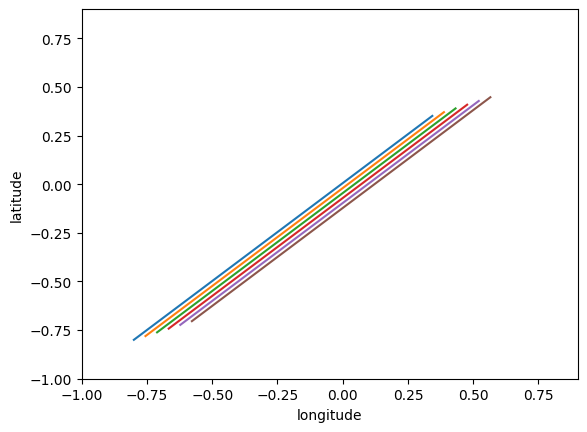

In [10]:
# visualise the fleet
ax = plt.axes()
ax.set_xlim([lons[0], lons[-1]])
ax.set_ylim([lats[0], lats[-1]])
for fl in flights:
    fl.plot(ax=ax)

In [11]:
# estimate fuel flow and fuel burn using ps_model

ps_model = PSFlight()
emi = Emissions()

for i, fl in enumerate(flights):
    
    # # downselect met data to the flight trajectory
    fl["air_temperature"] = models.interpolate_met(met, fl, "air_temperature")
    fl["specific_humidity"] = models.interpolate_met(met, fl, "specific_humidity")
    fl["true_airspeed"] = fl.segment_groundspeed()
    
    # get ac performance data using Poll-Schumann Model
    fl = ps_model.eval(fl)

    # get emissions data
    fl = emi.eval(fl)

    # emission indices
    eis = {
    "co2_m": 3.16,
    "h2o_m": 1.23,
    "so2_m": 0.00084,
    "nvpm_m": fl["nvpm_ei_m"],
    "nox_m": fl["nox_ei"],
    "co_m": fl["co_ei"],
    # hydrocarbon speciation
    "hcho_m": 0.12 * fl["hc_ei"], # formaldehyde
    "ch3cho_m": 0.04 * fl["hc_ei"], # acetaldehyde
    "c2h4_m": 0.15 * fl["hc_ei"], # ethylene
    "c3h6_m": 0.04 * fl["hc_ei"], # propene
    "c2h2_m": 0.04 * fl["hc_ei"], # acetylene
    "benzene_m": 0.02 * fl["hc_ei"] # benzene
    }

    # calculate emission mass per metre squared for each species
    for species, ei in eis.items():
        fl[species] = (ei * fl["fuel_flow"] / fl["true_airspeed"]) / chem_params["vres_chem"] / 1E+03 # why divide by 1E+03? g or kg

In [12]:
# simulate plume dispersion/advection
dry_adv = DryAdvection(met, plume_params)

plumes = []

for fl in flights:
    pl = dry_adv.eval(fl)
    plumes.append(pl)

plumes[0]

GeoVectorDataset [19 keys x 1116 length, 1 attributes]
	Keys: dsn_dz, waypoint, sigma_yz, longitude, u_wind, ..., latitude
	Attributes:
	time                [2022-03-02 21:05:00, 2022-03-03 00:30:00]
	longitude           [-0.8, 0.343]
	latitude            [-0.8, 0.351]
	altitude            [11500.0, 11500.0]
	crs                 EPSG:4326

In [13]:
# run boxm simulation and generate chemistry dataset
# chem = Boxm()